This Project is to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, it is conformed from the previous steps that Linear Regression Moldel and User Based Recommendation System gives the highest accuracy among the other models. 

Hence, first Linear Regression model is built and proceeding further with User Based Recommendation System.










Data sourcing and sentiment analysis by Linear Regression Model

In [1]:
## mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')


MessageError: ignored

Import and Install useful packages.

In [3]:
## General Purpose Library

import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,balanced_accuracy_score

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

#Modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
product_data = pd.read_csv("/content/sample30.csv")

**EDA of the data set given**

In [5]:
## null column check
product_data.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [6]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
## dropping null values from user_sentiment column
df = product_data.dropna(subset=['user_sentiment'])

In [8]:
## checking null values columns

df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14067
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28070
reviews_userProvince    29830
reviews_username           63
user_sentiment              0
dtype: int64

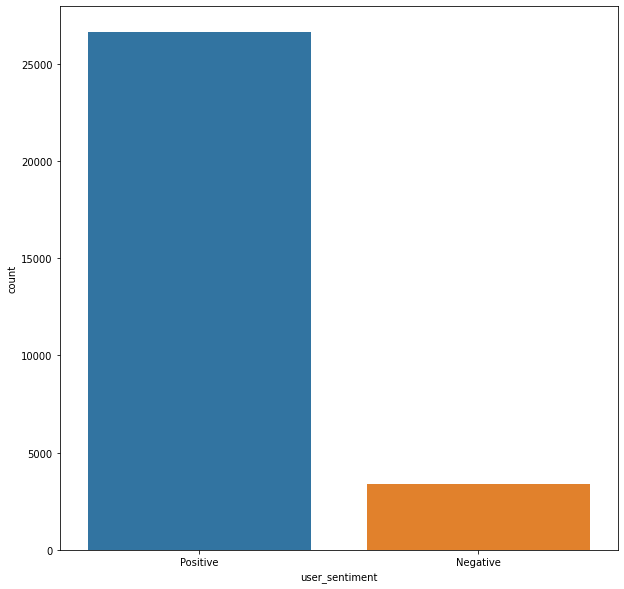

In [9]:
#plotting application data distribution
plt.figure(figsize= (10,10))
sns.countplot(x='user_sentiment', data= df)
plt.show()

In [10]:
## total no. in each user_sentiment
product_data['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [11]:
# mapping the positive sentiments as 1 and negative as 0
df['user_sentiment']= df['user_sentiment'].map({'Positive':1 , 'Negative':0})

**Text Preprocessing**

In [12]:
#converting into string
df['reviews_text'] = df['reviews_text'].astype('str')

In [13]:
# Remove punctuation 
df['reviews_text'] = df['reviews_text'].str.replace('[^\w\s]','')

In [14]:
# Remove Stopwords
stop = stopwords.words('english')
df['reviews_text'] = df['reviews_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [15]:
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)"," ",text)
    
    # remove unneccessary words
    text = text.replace("RE:","")
    text = text.replace("FW:","")
    text = text.replace("_"," ")
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text = text.strip()
    text = re.sub(' +', ' ',text)
    
    return text

In [16]:
## applying scrub_words fuction through lambda
df['reviews_text']=df['reviews_text'].apply(lambda x: scrub_words(x))

In [17]:
#loercase the reviews_text
df['reviews_text']= df['reviews_text'].str.lower()

In [18]:
## creating lemmatizer object 
lemmatizer = nltk.stem.WordNetLemmatizer()

In [19]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [20]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [21]:
# assigning x= reviews & y=sentiment

x=df['reviews_text'] 
y=df['user_sentiment']

no_of_classes= len(pd.Series(y).value_counts())
print(no_of_classes)

2


Checking the distribution of class for class imbalance

In [22]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
  print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  11.22 %
Percent of 1s:  88.78 %


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
 X_train, X_test, y_train, y_test = train_test_split(df['reviews_text'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=42)

Creating a generic function which do below action
1. convert into vector the input 
2. as there are class imbalance present in the dataset handle that
3. save the vector pickle file
4. train the model 
5. save the model pickle file 
6. predict the test data
7. show the matrics of model performance


In [25]:
def model_split(df) :
    '''This function splits data to train and test, then vectorized reviews '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=42)
    print("X train ",X_train.shape)
    print("X test " ,X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english')

    word_vectorizer.fit(df['reviews_text'])
    
    # train - test vectorized features - tranforming to suitable format for modeling
    train_word_features = word_vectorizer.transform(X_train) 
    test_word_features = word_vectorizer.transform(X_test)

    # handling class imbalance 
    counter = Counter(y_train)
    print('Before',counter)
    sm = SMOTE()
    X_train_transformed_sm, y_train_sm = sm.fit_resample(train_word_features, y_train)
    counter = Counter(y_train_sm)
    print('After',counter)
    pickle.dump(word_vectorizer.vocabulary_, open("vector.pkl", "wb"))
    return X_train_transformed_sm , test_word_features, y_train_sm, y_test 

def model(df,classifier,filename):
    '''this function gives modeling results and confusion matrix also'''
    train_word_features,test_word_features,y_train,y_test = model_split(df)
    classifier.fit(train_word_features, y_train)
    
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
    
    #for smart printing (learned from our lead instructor Bryan Arnold)
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    print(y_pred.shape)
    print(classification_report(y_pred_train, y_train))
    with open(filename, 'wb') as files:
      pickle.dump(classifier, open(filename, 'wb'))
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

In [26]:
from mlxtend.plotting import plot_confusion_matrix

X train  (23999,)
X test  (6000,)
Before Counter({1: 21285, 0: 2714})
After Counter({0: 21285, 1: 21285})
Accuracy:
TRAIN: 0.9522433638712708
TEST: 0.9078333333333334

Balanced Accuracy:
TRAIN: 0.9522433638712708
TEST: 0.909974135000348
(6000,)
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22740
           1       0.92      0.99      0.95     19830

    accuracy                           0.95     42570
   macro avg       0.95      0.95      0.95     42570
weighted avg       0.95      0.95      0.95     42570



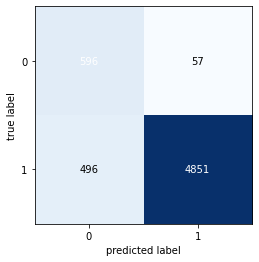

In [27]:
### checking through LogisticRegression

classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
model(df,classifier,"LRModel")

In [28]:
test = df[df['name'] == 'Red (special Edition) (dvdvideo)']
test_data = test['reviews_text']
test_data

5591    overall cute tongue cheek comedy decent cinematography points alas like took expendables actually tried hard make another expendables worth rent dollar list
5592                                                                                                                   bought sale i enjoy cast wasnt i expected bad
5593                                                                                                                                 ok movie gift somebody i bought
5594                                                                                   bought black friday price great i like movie easy watch typical shootem movie
5595                                                          i thought movie alright i lost interest even halfway i watch whole thing it action i prefer movies one
                                                                                    ...                                                                             
6258      

Building a recommendation system

*   User based recommendation
*   User based prediction & evaluation


In [30]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
#reading ratings file
reviews = pd.read_csv('/content/sample30.csv')

In [32]:
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


**Dividing train and test dataset**

In [33]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(reviews, test_size=0.30, random_state=31)

In [34]:
print(train.shape)
print(test.shape)

(21000, 15)
(9000, 15)


In [35]:
# Pivot the train ratings dataset into matrix format in which columns are product_names and the rows are reviewers_name.
df_pivot= train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
#    aggfunc=lambda x: ' '.join(x.dropna())
).fillna(0)

df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gel

In [36]:
## checking sample username
reviews[reviews['reviews_username'] =='joshua']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1559,AVpe31o71cnluZ0-YrSD,Warner Bros.,"Movies, Music & Books,Movies,Comedy,Movies & TV,Misc,Instawatch Movies By VUDU,Shop Instawatch,Movies & Music,Movies & TV Shows,Instawatch,Electronics, Tech Toys, Movies, Music,DVDs,See ALL DVDs",TIME WARNER,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),2016-06-13T00:00:00.000Z,NaN,True,3,Silly movie but is generally pretty funny. I recommend.,Silly but good,NaN,NaN,joshua,Negative
5616,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Shop Instawatch,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Movies & Music,Special Editions,Comedy,Studio Specials,Instawatch",Summit Entertainment,Red (special Edition) (dvdvideo),2017-05-18T00:00:00.000Z,NaN,True,4,Red is one of the few comic book adaptations that gets it right.,Red is a good film,NaN,NaN,joshua,Positive
17859,AVpfBwE4ilAPnD_xTWO1,Smead,"School & Office Supplies,Filing,Files,File Folders,Office,Small Business Center,Small Business Bulk Buys,All Bulk Buys,Office Supplies,Office Organization,Home",SMEAD MANUFACTURING CO.,"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",2013-07-30T07:00:00.000Z,NaN,True,5,The company I work uses the Smead Green file backs with two fastners I have been using these for 3 years now. We have a filing closet wit hseveral filing cabinets where I am in charge of filing and keeping organized.. I have over 6000 files to organize and keep tidy. I love the Green File Folder...,File Folder Filing,Maitland,NaN,joshua,Positive
22742,AVpfoSS51cnluZ0-oVH9,Cheetos,"Food,Packaged Foods,Snacks,Chips & Pretzels,Snacks, Cookies & Chips,Chips,Popcorn,Food & Beverage,Cookies, Chips & Snacks,Featured Brands,Food & Beverage Ways To Shop,Tailgating Essentials,#133 in,#543 in,#25 in,grocery,Home & Garden,Food & Beverages,Snack Foods,Puffed Snacks,Food & Grocery,Othe...",Frito-Lay,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,2016-04-13T00:00:00.000Z,False,True,5,Awesome product my kids love it,Flaming hot cheetos,NaN,NaN,joshua,Positive


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [37]:
# Copy the train dataset into dummy_train

dummy_train = train.copy()

In [38]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

dummy_train.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
11155,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-05T00:00:00.000Z,False,True,0,"It's quick and easy compared to using a spray bottle, we like to keep them handy, I like to use them in my car too. This review was collected as part of a promotion.",Clorox wipes,NaN,NaN,gor05751,Positive
22114,AVpf--o9LJeJML43G_Fq,Vaseline,"Personal Care,Skin Care,Hand Cream,Beauty,Body Lotions & Creams,Featured Brands,Health & Beauty,Unilever,Holiday Shop,Christmas,Bath & Body,Hand Creams & Lotions,Nail Care, Manicure & Pedicure,Hand & Nail Treatment Creams,Moisturizers",Vaseline,Vaseline Intensive Care Healthy Hands Stronger Nails,2016-03-19T00:00:00.000Z,False,True,0,Stronger nails after a week of daily use. Not that much moistrurising for dry skin,VERY GOOD PRODUCT,NaN,NaN,annavsl,Positive
26218,AVpfPkrkilAPnD_xX-L9,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Natural Cleaning,Kitchen,Dishwasher Detergent,Household Supplies,Dish Detergent,Dishwashing,Health",Reckitt Benckiser,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct",2013-04-25T16:51:02.000Z,NaN,True,0,REALLY DOES CLEAN EVERYTHING AND SO GOOD ON GLASSES AS WELL,Excellent,NaN,NaN,bluenose,Positive
18966,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featured Brands,Home And Storage & Org,Clorox,All-purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Target Restock,Food & Grocery",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-21T00:00:00.000Z,False,True,0,These wipes are great for cleaning in the kitchen and smell wonderful,"Great wipes, great smell",NaN,NaN,kiki,Positive
29999,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-19T00:00:00.000Z,False,True,0,I received this product complimentary from influenster and it has really saved my hair. This product really gives the extra boost of health and strength to bring hair back to life. It hasn't helped my hair in so many ways. This review was collected as part of a promotion.,Conditioned into healthy,NaN,NaN,kcoopxoxo,Positive


In [39]:
# Convert the dummy train dataset into matrix format.
dummy_train= train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gel

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



# User Similarity Matrix

## Using Cosine Similarity

In [40]:
# Creating the User Similarity Matrix using pairwise_distance function.

from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [41]:
user_correlation.shape

(18252, 18252)

## Using adjusted Cosine 

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user


In [42]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

### Normalising the rating of the product for each user around 0 mean

In [43]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gel

### Finding cosine similarity

In [44]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [45]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [46]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

In [47]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gel

# Evaluation - User User 

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user instead of predicting it for the product not rated by the user. 

In [48]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2049, 15)

In [49]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Food,Ready to Drink Coffee",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health & Beauty,Johnson & Johnson Beauty,Johnson & Johnson,Beauty,Skin Care,Sun & Tanning,Health,Beauty & Personal Care,Sunscreens & Tanning Products,Sunscreens,Facial Sunscreens,Sun Protection & Tanning,Sunscreen,Body Sunscreens,Health & Wellness,Sun Prote...",Aveeno Baby,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and after using last week, her face broke out in patches of very red, rough & dry chapped places, like eczema. i had to put aquaphor on her patches for days until they cleared up. her chest and upper arms had a dry-type pink rash too. Im not going to be...",Not sensitive enough,NaN,NaN,kasheville,Positive
15098,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Binders and Accessories,All Binders,School & Office Supplies,Filing,File Dividers,Dividers",Avery Dennison,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",2009-08-11T00:00:00.000Z,NaN,True,5,"Wow, what a difference ease makes. Thanks for this product.",Best Ever,NaN,NaN,arlene,Positive
17968,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup,Lips,Holiday Shop,Christmas,Lip Balm,Facial Moisturizers,Featured Brands,Health & Beauty,Unilever,Toys,Health & Wellness,Medicine Cabinet,Lip Balms & Medications",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29T00:00:00.000Z,False,True,5,Love this product. Its amazing. Made my lips super soft and silky smooth.,wonderful,NaN,NaN,mimi3,Positive
28020,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2015-05-20T00:00:00.000Z,NaN,True,5,This movie is wonderful. It has a great story line and is enjoyable for all ages.,Great Family Movie,NaN,NaN,movielover,Positive


In [50]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [51]:
# Convert the user_correlation matrix into dataframe.

user_correlation_df = pd.DataFrame(user_correlation)

In [52]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [53]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [54]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_2

reviews_username,00sab00,1234,1234asdf,123charlie,1943,4cloroxl,4djs,7inthenest,85lisa,a hutch,aalyah,aaron,abbey,abc,abcgator,abigail,abismomy,ace24,acellacey,acg1,aclass,actionaction,adam,adamsmom,adizzione,adma2,adriana9999,ael26,afwifey2003,agmt,ah78,aisha,aj,aj1135,ajackson75,ajay,akesler19,akhan,alena125,alex,ali1353,allison33,ally,ally1989,allyj1984,alredhouse,aluns,amanda,amanda01,amandalynn,amandarose,amber0528,ambybambi0725,amerbamer,amgo2,ami35,amlyke,amor,amsmes26,amy00381,amy1,amy75,amyrn,anas79,anatnas4,andie,andrea,andream82,andrew,andy,ang32,angel,angela,angelbabee1965,angie,angie0104,angie2,angiesmessykids,ann222,anna,annie,annieb,anyab,aphoung,april,aprilg87,aprilrdh,aria,arlene,arlingtondonna,arob,artlile,aryalynn,as123,ash1,ash4,ashleyfawne,ashsmash,athenabear,atid,...,tinaj,tink,tisha9878,tjacksonn,tjzmom,tman,tmoeb,tmoxvan,tobaira,toby,todd,toddster7,tommty41,toni,tony,tony1,tooney38,toots,totesaddicted,tracelyn28,tredsoftball,treese,trice,trina,trish626,trisha27,trix,truckinbarbie,truth,ttop,turtle,tweetyanne,twin,txmomof6,tycr,typist,tyreese,unhappy cus to mer,unicorn351,val,valentinebarrera,valerie,vc13,venus24,vet323tech,vicki,vickie,vickie49464,vicocious,victor,viewer,viking80,vikki,viper,vivian,vivienne,vkay,vlo910,voxemluth,walker,wally,walt,wasabi42,watson28,weewee,wendy,wendy2245,wendy59,wendydarling,wernigcourtney,whythis,wil27,wildclay12,wildman,willy,windowkitty,wise,wizard,wjb1,wolvarine,woody,woottos,worm,wowiezowie,wowwie,xavier,xcoupon,xmom,yazzmiin,yellow,ygtz,yoadrian,yohnie1,yummy,yvonne,zach,zapman,zburt5,zebras,zmom
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,

In [55]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3

,00sab00,1234,1234asdf,123charlie,1943,4cloroxl,4djs,7inthenest,85lisa,a hutch,aalyah,aaron,abbey,abc,abcgator,abigail,abismomy,ace24,acellacey,acg1,aclass,actionaction,adam,adamsmom,adizzione,adma2,adriana9999,ael26,afwifey2003,agmt,ah78,aisha,aj,aj1135,ajackson75,ajay,akesler19,akhan,alena125,alex,ali1353,allison33,ally,ally1989,allyj1984,alredhouse,aluns,amanda,amanda01,amandalynn,amandarose,amber0528,ambybambi0725,amerbamer,amgo2,ami35,amlyke,amor,amsmes26,amy00381,amy1,amy75,amyrn,anas79,anatnas4,andie,andrea,andream82,andrew,andy,ang32,angel,angela,angelbabee1965,angie,angie0104,angie2,angiesmessykids,ann222,anna,annie,annieb,anyab,aphoung,april,aprilg87,aprilrdh,aria,arlene,arlingtondonna,arob,artlile,aryalynn,as123,ash1,ash4,ashleyfawne,ashsmash,athenabear,atid,...,tinaj,tink,tisha9878,tjacksonn,tjzmom,tman,tmoeb,tmoxvan,tobaira,toby,todd,toddster7,tommty41,toni,tony,tony1,tooney38,toots,totesaddicted,tracelyn28,tredsoftball,treese,trice,trina,trish626,trisha27,trix,truckinbarbie,truth,ttop,turtle,tweetyanne,twin,txmomof6,tycr,typist,tyreese,unhappy cus to mer,unicorn351,val,valentinebarrera,valerie,vc13,venus24,vet323tech,vicki,vickie,vickie49464,vicocious,victor,viewer,viking80,vikki,viper,vivian,vivienne,vkay,vlo910,voxemluth,walker,wally,walt,wasabi42,watson28,weewee,wendy,wendy2245,wendy59,wendydarling,wernigcourtney,whythis,wil27,wildclay12,wildman,willy,windowkitty,wise,wizard,wjb1,wolvarine,woody,woottos,worm,wowiezowie,wowwie,xavier,xcoupon,xmom,yazzmiin,yellow,ygtz,yoadrian,yohnie1,yummy,yvonne,zach,zapman,zburt5,zebras,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [56]:
user_correlation_df_3.shape

(1728, 1728)

In [57]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

dummy_test.shape

(1728, 126)

In [59]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home Health Hairever Shampoo,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (twin) Aqua - 7pc,"Kikkoman Soy Sauce, 5fl oz",Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,Kind Nut Delight Bar,Kraus FVS-1007 Single Hole Vessel Bathroom Faucet from the Ramus Collection,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,"L'oreal Paris Visible Lift Smooth Absolute, Natural Buff",Leslie Sansone:Belly Blasting Walk (dvd),Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,"Lundberg Wehani Rice, 25lb",Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer,"Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz","Newman's Own Organics Licorice Twist, Black 5oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-breakage Ker

Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [60]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [61]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [62]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print("RMSE of User based Similarity : ",rmse)

RMSE of User based Similarity :  2.5181172953981728


In [63]:
import pickle 
pickle.dump(user_final_rating, open("user_based_recomm.pkl", "wb"))


In [64]:
def prediction(name):
    reviews = pd.read_csv('/content/sample30.csv')
    pipeline = pickle.load(open('user_based_recomm.pkl', 'rb'))
    sr = pipeline.loc[name].sort_values(ascending=False)[0:20] ## series
    top_20_products = pd.DataFrame({'name':sr.index})
    top_20_reviews = reviews[reviews['name'].isin(top_20_products['name'])][['name','reviews_text']] 
    transformer = TfidfTransformer()
    loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open('vector.pkl', 'rb')))
    test_data_features = transformer.fit_transform(loaded_vec.fit_transform(top_20_reviews['reviews_text']))
    loaded_model = pickle.load(open("LRModel", 'rb'))
    result1 = loaded_model.predict(test_data_features)
    top_20_reviews['sentiment'] = result1.tolist()
    top = top_20_reviews.groupby(['name']).mean()
    top5 = top.sort_values(by='sentiment',ascending=False)[:5]
    top5.reset_index(level=0, inplace=True)
    top_5_products= top5['name']
    top_5_product = pd.DataFrame({'name':top_5_products})
    return top_5_product  

